In [1]:
from pyiron_ising import Project
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from matplotlib.gridspec import GridSpec
import numpy as np

In [2]:
pr = Project('higherD')
# pr.remove_jobs(recursive=True)

In [20]:
class Experiment:
    def __init__(self, pr, spins, d2_reps=32, d3_reps=8, results=None):
        self.project = pr
        self.spins = spins
        self.d2_reps = d2_reps
        self.d3_reps = d3_reps

        self.results = {} if results is None else results

        self.labels = ['Boundary', 'BCluster']
        self.linestyles = ['-', '--']
        self.colors = sns.color_palette(n_colors=3)
        self.times = [25, 50, 100, 200]
        self.markers = ['o', 's', '^']

    def run(self, n_steps=200, n_print=1, delete_existing_job=False):
        for ns in self.spins:
            models = {
                'Square': self.project.ising.model.Square2D(n_spins=ns, repetitions=self.d2_reps),
                'Hex': self.project.ising.model.Hex2D(n_spins=ns, repetitions=self.d2_reps),
                'BCC': self.project.ising.model.BCC3D(n_spins=ns, repetitions=self.d3_reps),
                'FCC': self.project.ising.model.FCC3D(n_spins=ns, repetitions=self.d3_reps)
            }
            self.results[ns] = {}

            for topology, model in models.items():
                self.results[ns][topology] = {
                    'swap': {
                        'mutations': [self.project.ising.mutation.Swap(imperfect_seeds_only=True)]
                    },
                    'maxsize': {
                        'mutations': [
                            self.project.ising.mutation.Cluster(
                                imperfect_seeds_only=True,
                                max_size=n + 1
                            )
                            for n in range(int(0.1 * len(model)))
                        ]
                    },
                }

                for k, v in self.results[ns][topology].items():
                    job = self.project.ising.job.Ising(
                        f's{ns}_{topology}_{k}',
                        delete_existing_job=delete_existing_job
                    )
                    job.input.model = model.copy()
                    for m in v['mutations']:
                        job.input.mutations.append(m)
                    job.input.n_steps = n_steps
                    job.input.n_print = n_print
                    job.run()
                    v['job'] = job

    def evolution(self, topo, figsize, marker_size, times=None, equal_aspect=False):
        times = self.times if times is None else times
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        n_cols = 4
        n_rows = 1 + len(times)
        gs = GridSpec(n_rows, n_cols, figure=fig)

        def show_frame(ax, job, marks, t):
            for i, m in enumerate(marks):
                mask = job.output.genome[t] == i
                xy = job.model.structure.positions[mask].T[:2]
                ax.scatter(xy[0, :], xy[1, :], s=marker_size, marker=m, color=self.colors[i])
                # ax.axis('off')
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                if equal_aspect:
                    ax.set_aspect('equal')

        fit = fig.add_subplot(gs[0, :])
        snapshots = [[fig.add_subplot(gs[i, j]) for i in range(1, n_rows)] for j in range(n_cols)]

        for i_spin, spin in enumerate(self.spins):
            for i_mutation, (k, mutation) in enumerate(self.results[spin][topo].items()):
                job = self.results[spin][topo][k]['job']
                job.plot(
                    ax=fit,
                    show_success_log=False,
                    show_legend=False,
                    label_line=False,
                    label=f'{spin}-spin {self.labels[i_mutation]}',
                    linestyle=self.linestyles[i_spin],
                    color=self.colors[i_mutation]
                )
                for j, time in enumerate(times):
                    show_frame(snapshots[j][i_mutation + 2 * i_spin], job, self.markers[:spin], time)

        for j, time in enumerate(times):
            snapshots[j][-1].set_xlabel(f'Step {time}')
        for i, ax in enumerate(snapshots[0]):
            ax.set_ylabel(self.labels[i % len(self.labels)])
        fit.legend(loc='upper center', ncol=4, fancybox=True, bbox_to_anchor=(0.5, 1.3))

        return fig

    def three_d(self, figsize):
        fig, axes = plt.subplots(nrows=2, sharex=True, figsize=figsize)
        for i_spin, spin in enumerate(self.spins):
            for i_topo, topo in enumerate(['BCC', 'FCC']):
                for i_mutation, (k, mutation) in enumerate(self.results[spin][topo].items()):
                    job = self.results[spin][topo][k]['job']
                    job.plot(
                        ax=axes[i_topo],
                        show_success_log=False,
                        show_legend=False,
                        label_line=False,
                        label_x=False,
                        label_y=False,
                        label=f'{spin}-spin {self.labels[i_mutation]}',
                        linestyle=self.linestyles[i_spin],
                        color=self.colors[i_mutation],
                    )
                    axes[i_topo].set_ylabel(f'{topo} Fitness')
        axes[1].legend(ncol=2, loc='lower center', fancybox=True, bbox_to_anchor=(0.4, -0.5))
        axes[1].set_xlabel('Step')
        axes[0].annotate('a)', xy=(0, 0), xytext=(-45, 0.55))
        axes[1].annotate('b)', xy=(0, 0), xytext=(-45, 0.7))
        fig.tight_layout()
        return fig

In [21]:
experiment = Experiment(pr, [2, 3])
experiment.run()

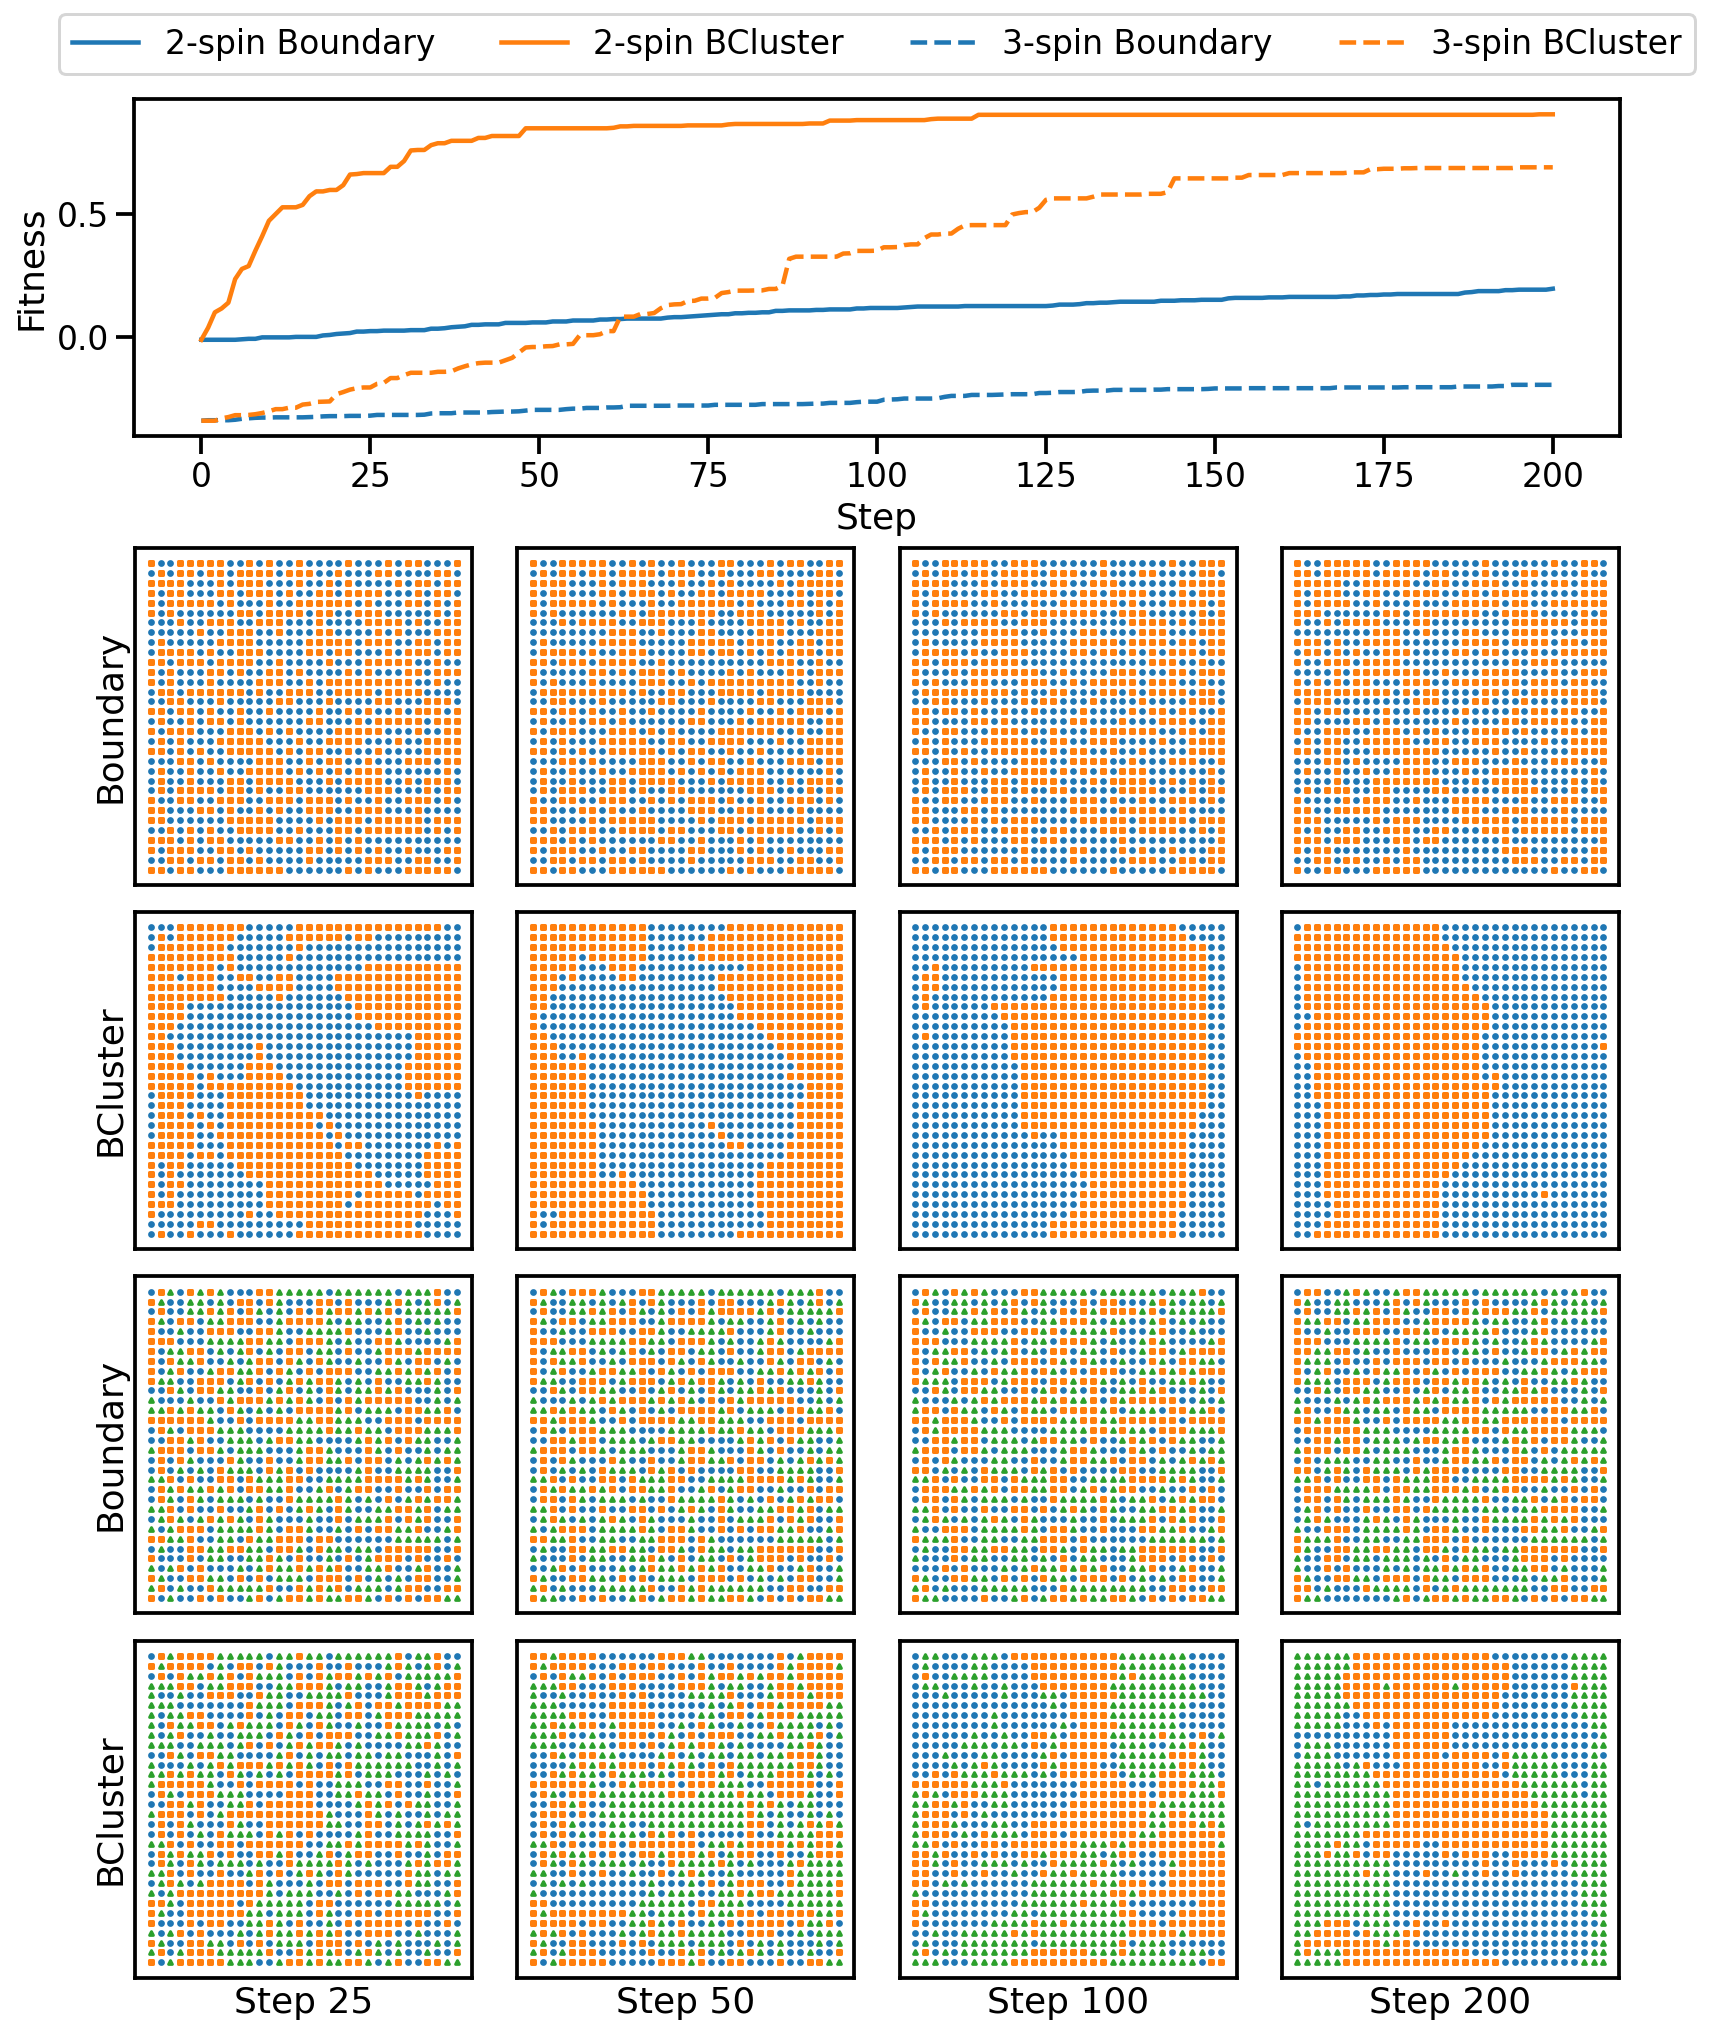

In [22]:
fig = experiment.evolution('Square', (12, 14), 3.5)
fig.savefig('../figs/square.eps', format='eps')

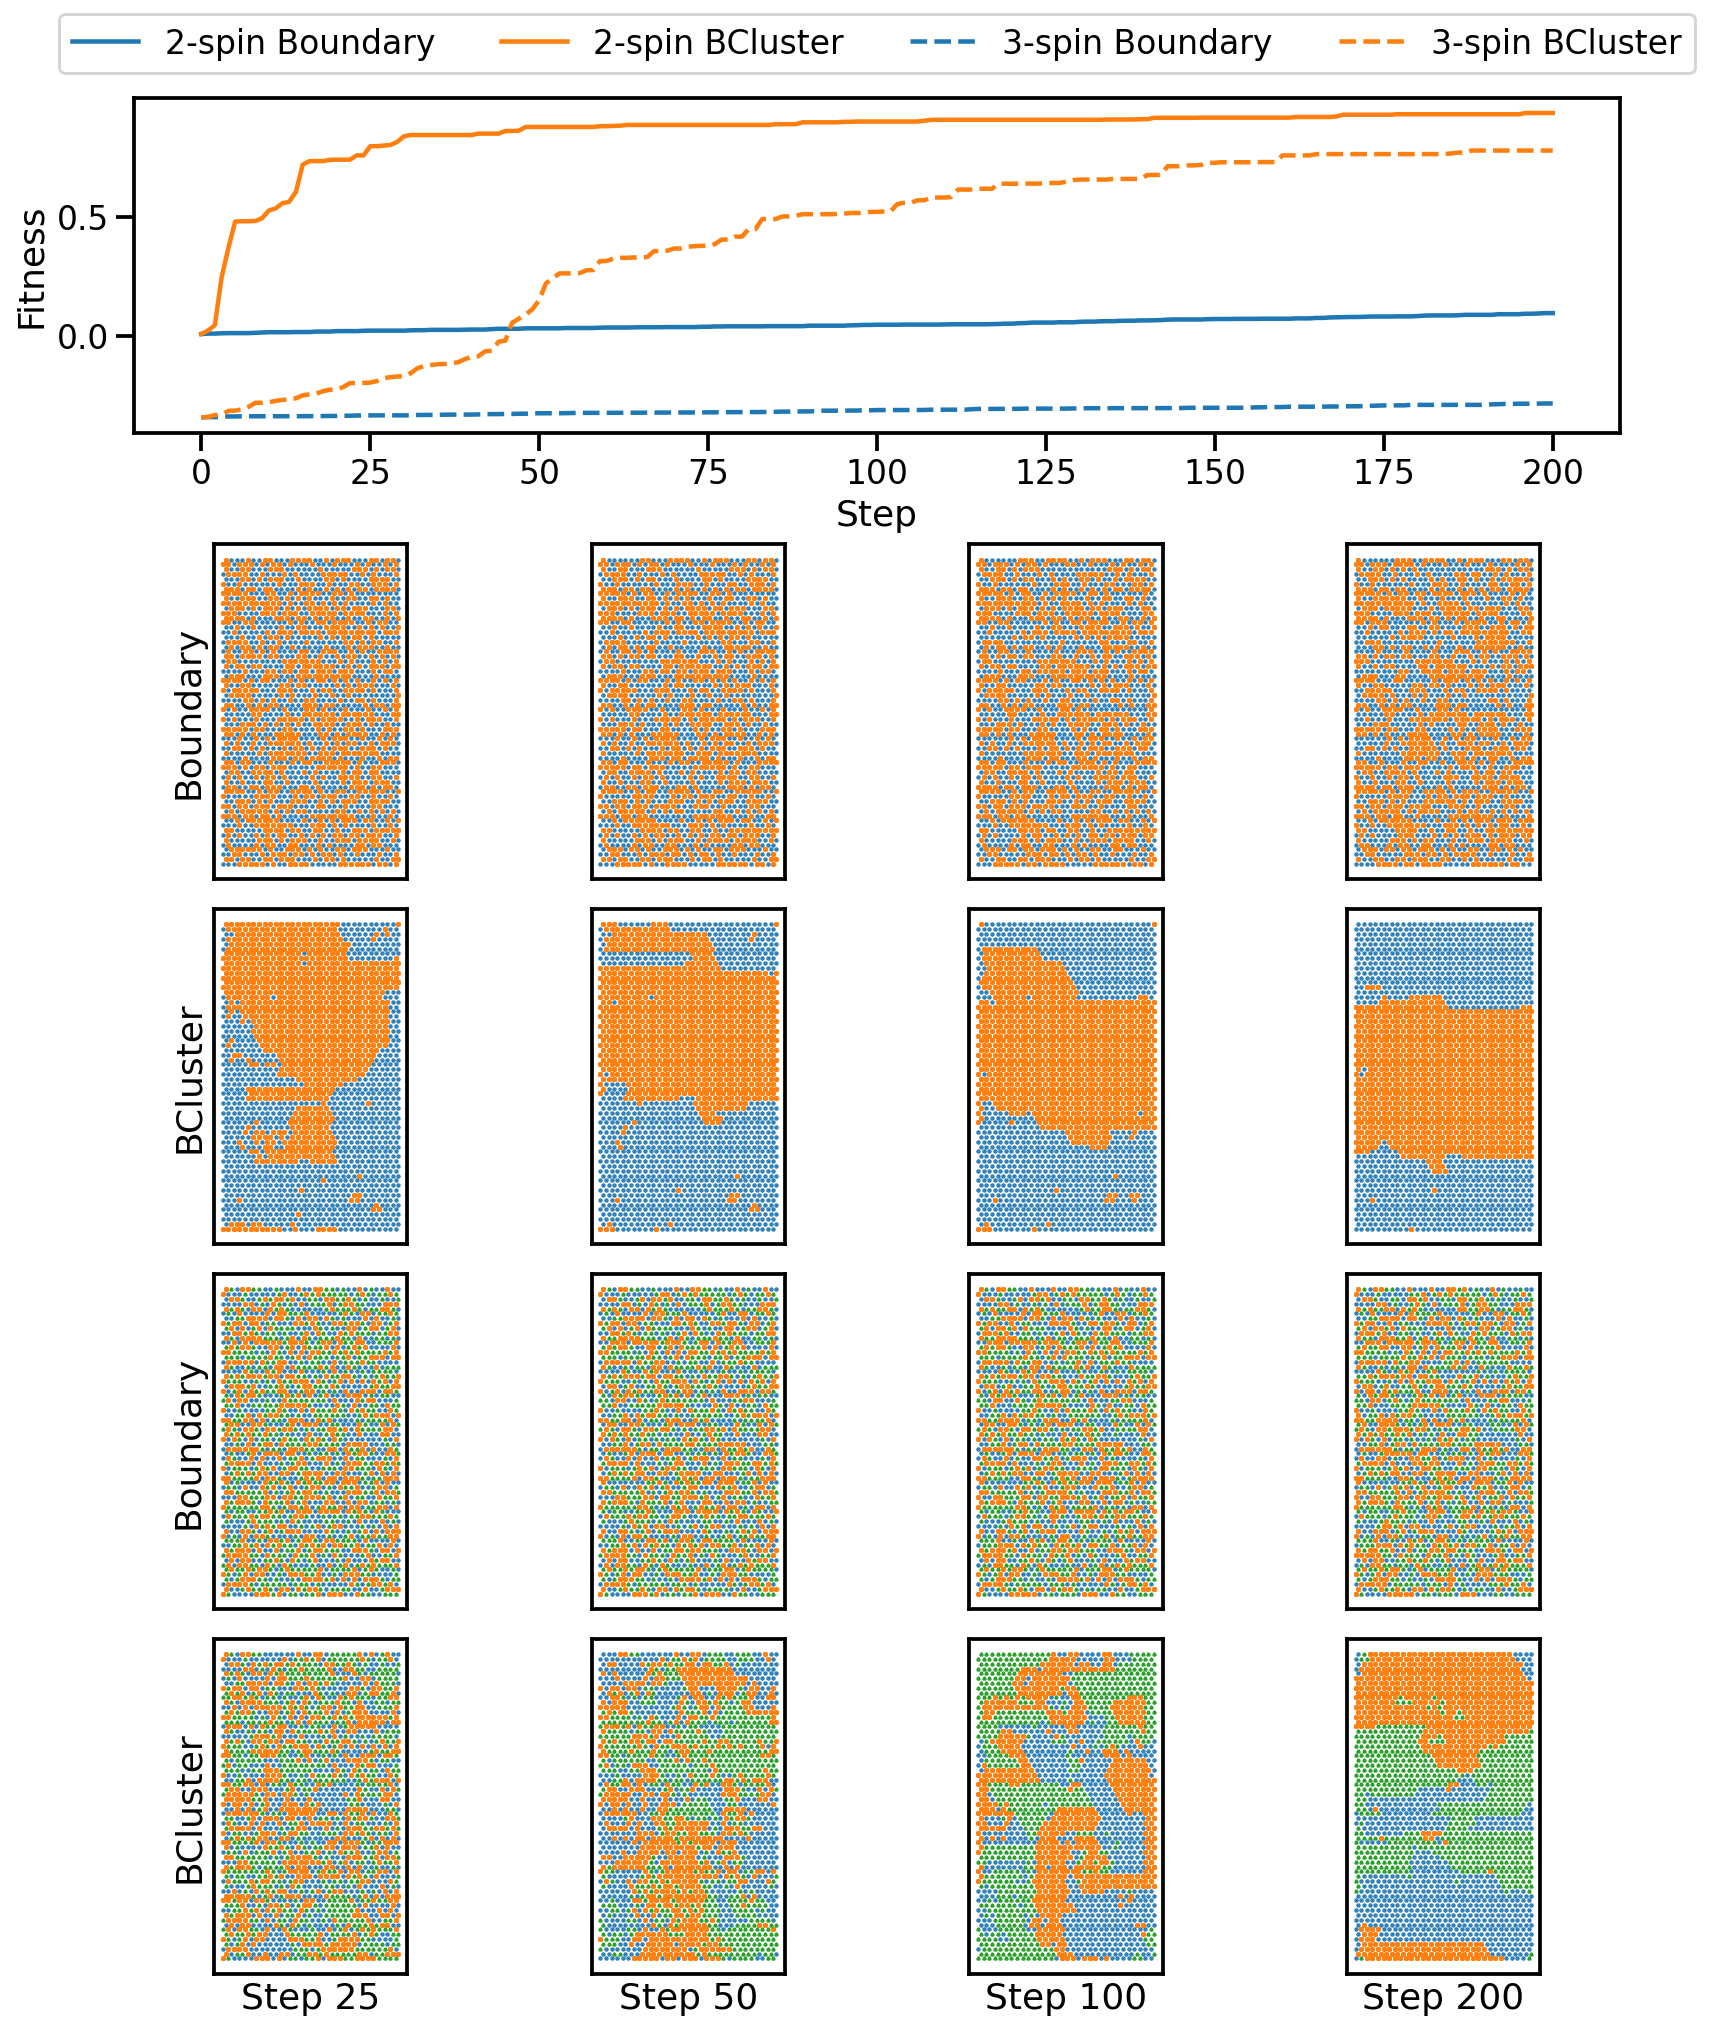

In [23]:
fig = experiment.evolution('Hex', (12, 14), 0.5)
fig.savefig('../figs/hex.eps', format='eps')

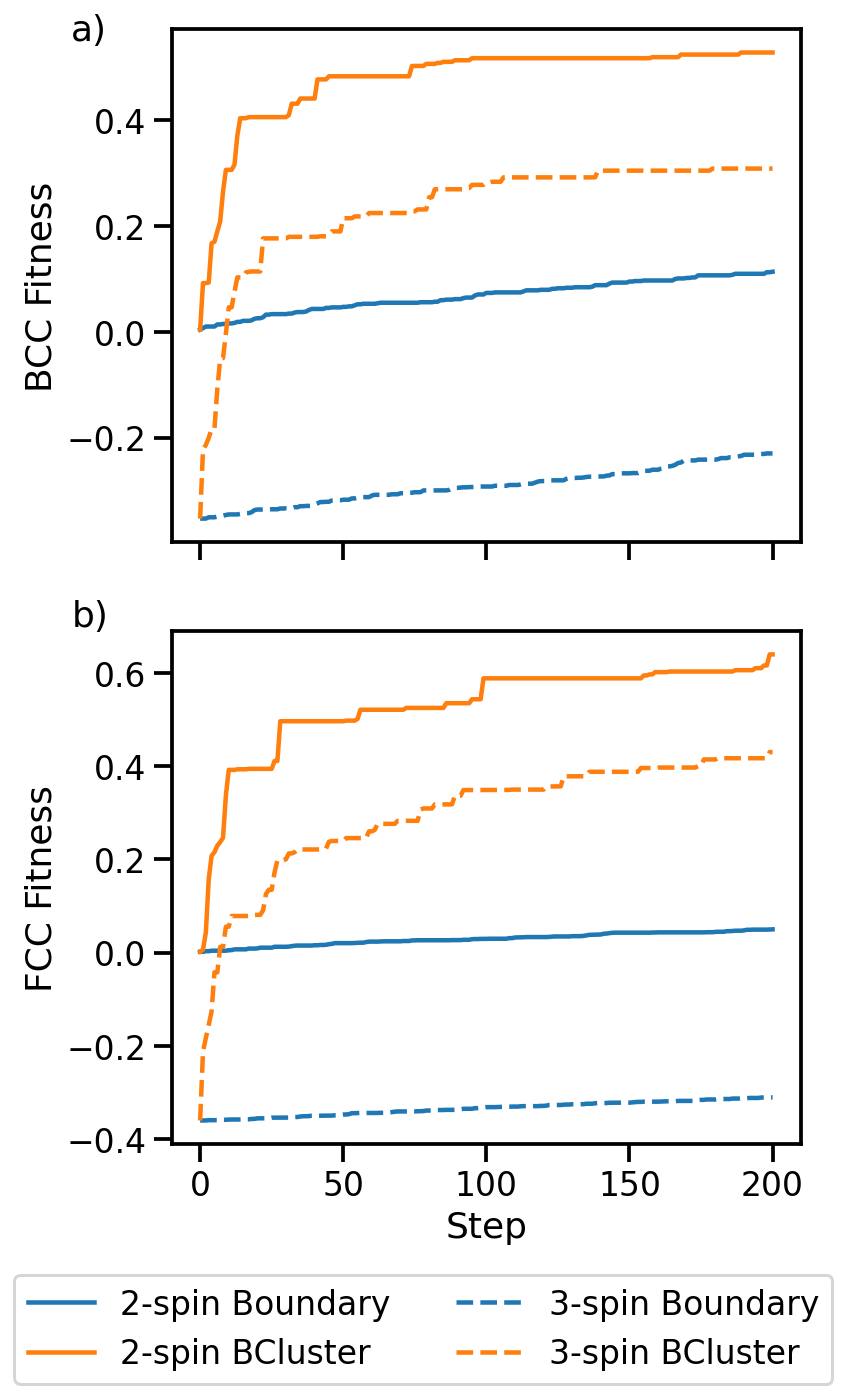

In [118]:
fig = experiment.three_d((6, 10))
fig.savefig('../figs/threed.eps', format='eps')